# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs
        
if not os.path.exists('tables'):
    !mkdir tables

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate, savefig

## Introduction

This notebook presents a new way to represent a degree of certainty, called "odds", and a new form of Bayes's Theorem, called Bayes's Rule.
Bayes's Rule is convenient if you want to do a Bayesian update on paper or in your head.
It also sheds light on the important idea of "evidence" and how we can quantify the strength of evidence.

The second part of the notebook is about "addends", that is, quantities being added, and how we can compute their distributions.
We'll define functions that compute the distribution of a sum, difference, or product of another operation.
And then we'll use those distributions as part of a Bayesian update.

As an exercise, you'll have a chance to solve the Congress problem:

> There are 538 members of the United States Congress.  
Suppose we audit their investment portfolios and find that 312 of them [outperform the market](https://en.wikipedia.org/wiki/Efficient-market_hypothesis).
Let's assume that an honest member of Congress has only a 50% chance of outperforming the market, but a dishonest member who [trades on inside information](https://en.wikipedia.org/wiki/Insider_trading) has a 90% chance.  How many members of Congress are honest?

## Odds

One way to represent a probability is with a number between 0 and 1, but that's not the only way.  
If you have ever bet on a football game or a horse race, you have probably encountered another representation of probability, called **odds**.

You might have heard expressions like "the odds are
three to one", but you might not know what that means.  
The **odds in favor** of an event are the ratio of the probability
it will occur to the probability that it will not.

So if I think my team has a 75% chance of winning, I would
say that the odds in their favor are three to one, because
the chance of winning is three times the chance of losing.

You can write odds in decimal form, but it is also common to
write them as a ratio of integers.  So "three to one" is
written $3:1$.

When probabilities are low, it is more common to report the
**odds against** rather than the odds in favor.  For
example, if I think my horse has a 10% chance of winning,
I would say that the odds against are $9:1$.

Probabilities and odds are different representations of the
same information.  Given a probability, you can compute the
odds like this:

In [4]:
def odds(p):
    return p / (1-p)

Given the odds in favor, in decimal form, you can convert to probability like this:

In [5]:
def prob(o):
    return o / (o+1)

If you represent odds with a numerator and denominator, you can convert to probability like this:

In [6]:
def prob2(yes, no):
    return yes / (yes + no)

If 20% of bettors think my horse will win, that corresponds to odds of 1:4, or 0.25.

In [7]:
p = 0.2
odds(p)

0.25

If the odds against my horse are 1:5, that corresponds to a probability of 1/6.

In [8]:
o = 1/5
prob(o)

0.16666666666666669

## Bayes's Rule

In Chapter 1 I wrote Bayes’s theorem in the "probability form": 

$P(H|D) = \frac{P(H)~P(D|H)}{P(D)}$

Writing $\mathrm{odds}(A)$ for odds in favor of $A$, we can express Bayes's Theorem in "odds form":

$\mathrm{odds}(A|D) = \mathrm{odds}(A)~\frac{P(D|A)}{P(D|B)}$

This is Bayes’s Rule, which says that the posterior odds are the prior odds times the
likelihood ratio.

Bayes’s Rule is convenient for computing a Bayesian update on paper or in your head. For example, let’s go back to the cookie problem:

> Suppose there are two bowls of cookies. Bowl 1 contains 30 vanilla
> cookies and 10 chocolate cookies. Bowl 2 contains 20 of each.
>
> Now suppose you choose one of the bowls at random and, without
> looking, select a cookie at random. The cookie is vanilla. What is the
> probability that it came from Bowl 1?

The prior probability is 50%, so the prior odds are $1$. The likelihood
ratio is $\frac{3}{4} / \frac{1}{2}$, or $3/2$. So the posterior odds
are $3/2$, which corresponds to probability $3/5$.

In [9]:
prior_odds = 1
likelihood_ratio = 0.75 / 0.5
post_odds = prior_odds * likelihood_ratio
post_odds

1.5

In [10]:
post_prob = prob(post_odds)
post_prob

0.6

If we draw another cookie and it's chocolate, we can do another update:

In [11]:
likelihood_ratio = 0.25 / 0.5
post_odds *= likelihood_ratio
post_odds

0.75

And convert back to probability.

In [12]:
post_prob = prob(post_odds)
post_prob

0.42857142857142855

## Oliver's blood

I’ll use Bayes’s Rule to solve another problem from MacKay’s
[*Information Theory, Inference, and Learning Algorithms*](https://www.inference.org.uk/mackay/itila/):

> Two people have left traces of their own blood at the scene of a
> crime. A suspect, Oliver, is tested and found to have type ‘O’ blood.
> The blood groups of the two traces are found to be of type ‘O’ (a
> common type in the local population, having frequency 60%) and of type
> ‘AB’ (a rare type, with frequency 1%). Do these data \[the traces
> found at the scene\] give evidence in favor of the proposition that
> Oliver was one of the people \[who left blood at the scene\]?

To answer this question, we need to think about what it means for data
to give evidence in favor of (or against) a hypothesis. Intuitively, we
might say that data favor a hypothesis if the hypothesis is more likely
in light of the data than it was before.

In the cookie problem, the prior odds are $1$, or probability 50%. The
posterior odds are $3/2$, or probability 60%. So the vanilla cookie is
evidence in favor of Bowl 1.

Bayes’s Rule provides a way to make this intuition more precise. Again

$\mathrm{odds}(A|D) = \mathrm{odds}(A)~\frac{P(D|A)}{P(D|B)}$

Dividing through by $\mathrm{odds}(A)$, we get: 

$\frac{\mathrm{odds}(A|D)}{\mathrm{odds}(A)} = \frac{P(D|A)}{P(D|B)}$

The term on the left is the ratio of the posterior and prior odds. The term
on the right is the likelihood ratio, also called the **Bayes
factor**.

If the Bayes factor is greater than 1, that means that the data were
more likely under $A$ than under $B$. And that means that the odds are
greater, in light of the data, than they were before.

If the Bayes factor is less than 1, that means the data were less likely
under $A$ than under $B$, so the odds in favor of $A$ go down.

Finally, if the Bayes factor is exactly 1, the data are equally likely
under either hypothesis, so the odds do not change.

Let’s apply that to the problem at hand. If Oliver is one of the people
who left blood at the crime scene, he accounts for the ‘O’ sample; in
that case, the probability of the data is the probability that a random
member of the population has type ‘AB’ blood, which is 1%.

If Oliver did not leave blood at the scene, we have two samples to
account for. If we choose two random people from the population, what is
the chance of finding one with type ‘O’ and one with type ‘AB’? Well,
there are two ways it might happen: the first person might have type ‘O’
and the second ‘AB’, or the other way around. So the total probability
is $2 (0.6) (0.01) = 1.2%$.

Now we can compute the likelihood ratio:

In [13]:
like1 = 0.01
like2 = 2 * 0.6 * 0.01

likelihood_ratio = like1 / like2
likelihood_ratio

0.8333333333333334

Since the likelihood ratio is less than 1, the blood tests are evidence *against* the hypothesis that Oliver left blood at the scence.

But it is weak evidence.  For example, if the prior odds were 1 (that is, 50% probability), the posterior odds would be 0.83, which corresponds to a probability of 45%:

In [14]:
post_odds = 1 * like1 / like2
prob(post_odds)

0.45454545454545453

So this evidence doesn't "move the needle" very much.

This example is a little contrived, but it is demonstrates the
counterintuitive result that data *consistent* with a hypothesis are
not necessarily *in favor of* the hypothesis.

If this result still bothers you, this way of thinking might help: the
data consist of a common event, type ‘O’ blood, and a rare event, type
‘AB’ blood. If Oliver accounts for the common event, that leaves the
rare event unexplained. If Oliver doesn’t account for the ‘O’ blood, we
have two chances to find someone in the population with ‘AB’ blood. And
that factor of two makes the difference.

**Exercise:** Suppose other evidence made you 90% confident of Oliver's guilt.  How much would this exculpatory evidence change your beliefs?  What if you initially thought there was only a 10% chance of his guilt?

In [15]:
# Solution

post_odds = odds(0.9) * like1 / like2
prob(post_odds)

0.8823529411764706

In [16]:
# Solution

post_odds = odds(0.1) * like1 / like2
prob(post_odds)

0.0847457627118644

## Addends

Suppose you roll two dice and add them up. What is the distribution of
the sum? I’ll use the following function to create a `Pmf` that represents the
possible outcomes of a die:

In [17]:
def make_die(sides):
    """Pmf that represents a die with the given number of sides.
    
    sides: int
    
    returns: Pmf
    """
    outcomes = np.arange(1, sides+1)
    die = Pmf(1/sides, outcomes)
    return die

On a six-sided die, the outcomes are 1 through 6, all
equally likely.

In [18]:
die = make_die(6)
die

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


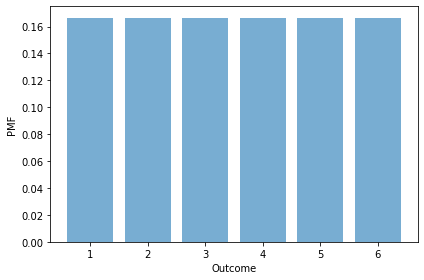

In [19]:
die.bar(alpha=0.6)
decorate(xlabel='Outcome',
         ylabel='PMF')

If we roll two dice and add them up, there are 11 possible outcomes, 2
through 12, but they are not equally likely. To compute the distribution
of the sum, we have to enumerate the possible outcomes. 

And that's how this function works:

In [20]:
def add_dist(pmf1, pmf2):
    """Compute the distribution of a sum.
    
    pmf1: Pmf
    pmf2: Pmf
    
    returns: Pmf of sums from pmf1 and pmf2
    """
    res = Pmf()
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            q = q1 + q2
            p = p1 * p2
            res[q] = res(q) + p
    return res

The parameters are `Pmf` objects representing distributions.
The first line creates an empty `Pmf`.

The loops use `items` to iterate though the quantities and probabilities in the `Pmf` objects.
Each time through the loop `q` gets the sum of a pair of quantities, and `p` gets the probability of the pair.
Because the same sum might appear more than once, we have to add up the total probability for each sum.

Notice a subtle element of this line:

```
            res[q] = res(q) + p
```

I use parentheses on the right side of the assignment, which returns 0 if `q` does not appear yet in `res`.
I use brackets on the left side of the assignment to create or update an element in `res`; using parentheses on the left side would not work.

`Pmf` provides `add_dist`, which does the same thing.
You can call it as a method, like this:

In [21]:
twice = die.add_dist(die)

Or as a function, like this:

In [22]:
twice = Pmf.add_dist(die, die)

And here's what the result looks like:

In [23]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

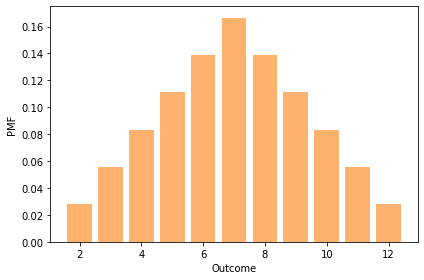

In [24]:
twice = add_dist(die, die)
twice.bar(color='C1', alpha=0.6)
decorate_dice()

If we have a sequence of `Pmf` objects that represent dice, we can compute the distribution of the sum like this:


In [25]:
def add_dist_seq(seq):
    """Distribution of sum of values from PMFs.
    
    seq: sequence of Pmf objects
    
    returns: Pmf
    """
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

So we can compute the sum of three dice like this:

In [26]:
dice = [die] * 3
thrice = add_dist_seq(dice)

The following figure shows what these three distributions look like:

-   The distribution of a single die is uniform from 1 to 6.

-   The sum of two dice has a triangle distribution between 2 and 12.

-   The sum of three dice has a bell-shaped distribution between 3
    and 18.

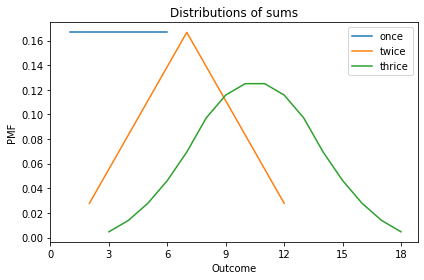

In [27]:
die.plot(label='once')
twice.plot(label='twice')
thrice.plot(label='thrice')

decorate_dice(title='Distributions of sums')
plt.xticks([0,3,6,9,12,15,18])
savefig('fig05-01')

As an aside, this example demonstrates the Central Limit Theorem, which
says that the distribution of a sum converges on a bell-shaped normal
distribution, at least under some conditions.

## Gluten sensitivity

In 2015 I read a paper that tested whether people diagnosed with gluten
sensitivity (but not celiac disease) were not able to distinguish gluten
flour from non-gluten flour in a blind challenge
([you can read the paper here](https://onlinelibrary.wiley.com/doi/full/10.1111/apt.13372)).

Out of 35 subjects, 12 correctly identified the gluten flour based on
resumption of symptoms while they were eating it. Another 17 wrongly
identified the gluten-free flour based on their symptoms, and 6 were
unable to distinguish.

The authors conclude, “Double-blind gluten challenge induces symptom
recurrence in just one-third of patients.”

This conclusion seems odd to me, because if none of the patients were
sensitive to gluten, we would expect some of them to identify the gluten
flour by chance. So here’s the question: based on this data, how many of
the subjects are sensitive to gluten?

We can use Bayes’s Theorem to answer this question, but first we have to
make some modeling decisions. I’ll assume:

-   People who are sensitive to gluten have a 95% chance of correctly
    identifying gluten flour under the challenge conditions, and

-   People who are not sensitive have a 40% chance of identifying the
    gluten flour by chance (and a 60% chance of either choosing the
    other flour or failing to distinguish).

These particular values are arbitrary, but the results are not sensitive
to these choices.

I will solve this problem in two steps. First, assuming that we know how
many subjects are sensitive, I will compute the distribution of the
data. Then, using the likelihood of the data, I will compute the
posterior distribution of the number of sensitive patients.

The first is the **forward problem**; the second is the **inverse
problem**.

## The forward problem

Suppose we know that 10 of the 35 subjects are sensitive to gluten. That
means that 25 are not:

In [ ]:
n = 35
n_sensitive = 10
n_insensitive = n - n_sensitive

Each sensitive subject has a 95% chance of identifying the gluten flour,
so the number of correct identifications follows a binomial distribution.

I'll use the following function to make a `Pmf` that represents the binomial distribution.

In [ ]:
from scipy.stats import binom

def make_binomial(n, p):
    """Make a binomial distribution.
    
    n: number of trials
    p: probability of success
    
    returns: Pmf representing the distribution of k
    """
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

Now we can compute distributions for the number of correct identifications in each group.

In [ ]:
dist_sensitive = make_binomial(n_sensitive, 0.95)
dist_insensitive = make_binomial(n_insensitive, 0.4)

We can use `add_dist` to compute the total number of correct identifications in both groups:

In [ ]:
dist_total = Pmf.add_dist(dist_sensitive, dist_insensitive)

Here are the results:

In [ ]:
dist_sensitive.plot(label='sensitive')
dist_insensitive.plot(label='insensitive')
dist_total.plot(label='total')

decorate(xlabel='Number of correct identifications',
         ylabel='PMF',
         title='Gluten sensitivity')

savefig('fig05-02')

We expect most of the sensitive subjects to identify the gluten flour correctly.
Of the 25 insensitive subjects, we expect about 10 to identify the gluten flour by chance.
So we expect about 20 correct identifications in total.

This is the answer to the forward problem: given the number of sensitive subjects, we can compute the distribution of the data.

## The inverse problem

Now let's solve the inverse problem: given the data, we'll compute the posterior distribution of the number of sensitive subjects.

Here's how.  I'll loop through the possible values of `n_sensitive` and compute the distribution of the data for each:

In [ ]:
table = pd.DataFrame()
table[0] = make_binomial(n, 0.4)

for n_sensitive in range(1, n):
    n_insensitive = n - n_sensitive

    dist_sensitive = make_binomial(n_sensitive, 0.95)
    dist_insensitive = make_binomial(n_insensitive, 0.4)
    dist_total = Pmf.add_dist(dist_sensitive, dist_insensitive)    
    table[n_sensitive] = dist_total
    
table[n] = make_binomial(n, 0.95)

When `n_sensitive` is 0 or `n`, the distribution of the data is a simple binomial, not the sum of two binomials.

The result is a Pandas `DataFrame`:

In [ ]:
table.head()

In [ ]:
table.tail()

The following figure shows several columns from this table, corresponding to several hypothetical values of `n_sensitive`:

In [ ]:
for n_sensitive in [0, 10, 20, 30]:
    table[n_sensitive].plot(label=f'n_sensitive = {n_sensitive}')
    
decorate(xlabel='Number of correct identifications',
         ylabel='PMF',
         title='Gluten sensitivity')

savefig('fig05-03')

Now we can use this table to compute the likelihood of the data:

In [ ]:
likelihood1 = table.loc[12]

`loc` selects a row from the table.
The row with index 12 contains the probability of 12 correct identifications for each hypothetical value of `n_sensitive`.
And that's exactly the likelihood we need to do a Bayesian update.

I'll use a uniform prior, which implies that I would be equally surprised by any value of `n_sensitive`:

In [ ]:
hypos = np.arange(n+1)
prior = Pmf(1, hypos)

And here's the update:


In [ ]:
posterior1 = prior * likelihood1
posterior1.normalize()

For comparison, I also compute the posterior for another hypothetical outcome, 20 correct identifications.

In [ ]:
likelihood2 = table.loc[20]
posterior2 = prior * likelihood2
posterior2.normalize()

The following figure shows posterior distributions of `n_sensitive` based on the actual data, 12 correct identifications, and another hypothetical outcome, 20 correct identifications.

In [ ]:
posterior1.plot(label='posterior with 12 correct')
posterior2.plot(label='posterior with 20 correct')

decorate(xlabel='Number of sensitive subjects',
         ylabel='PMF',
         title='Posterior distributions')

savefig('fig05-04')

With 12 correct identifications, the most likely conclusion is that none of the subjects are sensitive to gluten.
If there had been 20 correct identifications, the most likely conclusion would be that 11-12 of the subjects were sensitive.

In [ ]:
posterior1.max_prob()

In [ ]:
posterior2.max_prob()

## Summary

This chapter presents two topics that are almost unrelated except that they make the title of the chapter catchy.

The first part of the chapter is about Bayes's Rule, evidence, and how we can quantify the strength of evidence using a likelihood ratio or Bayes factor.

The second part is about functions that compute the distribution of a sum, product, or the result of another binary operation.
We can use these functions to solve a forward problem and inverse problems; that is, given the parameters of a system, we can compute the distribution of the data or, given the data, we can compute the distribution of the parameters.

In the following exercises, you'll have a chance to practice what you learned.

## Exercises

**Exercise:** Let's use Bayes's Rule to solve the Elvis problem from Chapter 2:

> Elvis Presley had a twin brother who died at birth. What is the probability that Elvis was an identical twin?

In 1935, about 2/3 of twins were fraternal and 1/3 were identical.

The question contains two pieces of information we can use to update this prior.

* First, Elvis's twin was also male, which is more likely if they were identical twins, with a likelihood ratio of 2.

* Also, Elvis's twin died at birth, which is more likely if they were identical twins, with a likelihood ratio of 1.25.

If you are curious about where those number come from, I wrote [a blog post about it](https://www.allendowney.com/blog/2020/01/28/the-elvis-problem-revisited).

In [ ]:
# Solution

prior_odds = odds(1/3)

In [ ]:
# Solution

post_odds = prior_odds * 2 * 1.25

In [ ]:
# Solution

prob(post_odds)

**Exercise:** The following is an [interview question that appeared on glassdoor.com](https://www.glassdoor.com/Interview/You-re-about-to-get-on-a-plane-to-Seattle-You-want-to-know-if-you-should-bring-an-umbrella-You-call-3-random-friends-of-y-QTN_519262.htm), attributed to Facebook:

> You're about to get on a plane to Seattle. You want to know if you should bring an umbrella. You call 3 random friends of yours who live there and ask each independently if it's raining. Each of your friends has a 2/3 chance of telling you the truth and a 1/3 chance of messing with you by lying. All 3 friends tell you that "Yes" it is raining. What is the probability that it's actually raining in Seattle?

Use Bayes's Rule to solve this problem.  As a prior you can assume that it rains in Seattle about 10% of the time.

This question causes some confusion about the differences between Bayesian and frequentist interpretations of probability; if you are curious about this point, [I wrote a blog article about it](http://allendowney.blogspot.com/2016/09/bayess-theorem-is-not-optional.html).

In [ ]:
# Solution

prior_odds = odds(0.1)

In [ ]:
# Solution

post_odds = prior_odds * 2 * 2 * 2

In [ ]:
# Solution

prob(post_odds)

**Exercise:** [According to the CDC](https://www.cdc.gov/tobacco/data_statistics/fact_sheets/health_effects/effects_cig_smoking), people who smoke are about 25 times more likely to develop lung cancer than nonsmokers.

[Also according to the CDC](https://www.cdc.gov/tobacco/data_statistics/fact_sheets/adult_data/cig_smoking/index.htm), about 14\% of adults in the U.S. are smokers. 

If you learn that someone has lung cancer, what is the probability they are a smoker?

In [ ]:
# Solution

prior_odds = odds(0.14)

In [ ]:
# Solution

post_odds = prior_odds * 25

In [ ]:
# Solution

prob(post_odds)

**Exercise:** In *Dungeons & Dragons*, the amount of damage a goblin can withstand is the sum of two six-sided dice. The amount of damage you inflict with a short sword is determined by rolling one six-sided die.
A goblin is defeated if the total damage you inflict is greater than or equal to the amount it can withstand.

Suppose you are fighting a goblin and you have already inflicted 3 points of damage. What is your probability of defeating the goblin with your next successful attack?

Hint: You can use `Pmf.add_dist` to add a constant amount, like 3, to a `Pmf` and `Pmf.sub_dist` to compute the distribution of remaining points.

In [ ]:
# Solution

d6 = make_die(6)

In [ ]:
# Solution
# The amount the goblin can withstand is the sum of two d6
hit_points = Pmf.add_dist(d6, d6)

In [ ]:
# Solution
# The total damage after a second attack is one d6 + 3
damage = Pmf.add_dist(d6, 3)

In [ ]:
# Solution
# Here's what the distributions look like
hit_points.plot(label='Hit points')
damage.plot(label='Total damage')
decorate_dice('The Goblin Problem')

In [ ]:
# Solution

points_left = Pmf.sub_dist(hit_points, damage)

In [ ]:
# Solution

dead = points_left.qs <= 0
points_left[dead].sum()

**Exercise:** Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
I choose one of the dice at random, roll it twice, multiply the outcomes, and report that the product is 12.
What is the probability that I chose the 8-sided die?

Hint: `Pmf` provides a function called `mul_dist` that takes two `Pmf` objects and returns a `Pmf` that represents the distribution of the product.

In [ ]:
# Solution

hypos = [6, 8, 12]
prior = Pmf(1, hypos)

In [ ]:
# Solution

# Here's the distribution of the product for the 4-sided die

d4 = make_die(4)
Pmf.mul_dist(d4, d4)

In [ ]:
# Solution

likelihood = []

for sides in hypos:
    die = make_die(sides)
    pmf = Pmf.mul_dist(die, die)
    likelihood.append(pmf[12])
    
likelihood

In [ ]:
# Solution

posterior = prior * likelihood
posterior.normalize()
posterior

**Exercise:** *Betrayal at House on the Hill* is a strategy game in which characters with different attributes explore a haunted house.  Depending on their attributes, the characters roll different numbers of dice.  For example, if attempting a task that depends on knowledge, Professor Longfellow rolls 5 dice, Madame Zostra rolls 4, and Ox Bellows rolls 3.  Each die yields 0, 1, or 2 with equal probability.  

If a randomly chosen character attempts a task three times and rolls a total of 3 on the first attempt, 4 on the second, and 5 on the third, which character do you think it was?

In [ ]:
# Solution

die = Pmf(1/3, [0,1,2])
die

In [ ]:
# Solution

pmfs = {}
pmfs['Bellows'] = add_dist_seq([die]*3)
pmfs['Zostra'] = add_dist_seq([die]*4)
pmfs['Longfellow'] = add_dist_seq([die]*5)

In [ ]:
# Solution

pmfs['Zostra'](4)

In [ ]:
# Solution

pmfs['Zostra']([3,4,5]).prod()

In [ ]:
# Solution

hypos = pmfs.keys()
prior = Pmf(1/3, hypos)
prior

In [ ]:
# Solution

likelihood = prior.copy()

for hypo in hypos:
    likelihood[hypo] = pmfs[hypo]([3,4,5]).prod()

likelihood

In [ ]:
# Solution

posterior = (prior * likelihood)
posterior.normalize()
posterior

**Exercise:** There are 538 members of the United States Congress.  
Suppose we audit their investment portfolios and find that 312 of them out-perform the market.
Let's assume that an honest member of Congress has only a 50% chance of out-performing the market, but a dishonest member who trades on inside information has a 90% chance.  How many members of Congress are honest?

In [ ]:
# Solution

n = 538

table = pd.DataFrame()
table[0] = make_binomial(n, 0.9)

for n_honest in range(1, n):
    n_dishonest = n - n_honest

    dist_honest = make_binomial(n_honest, 0.5)
    dist_dishonest = make_binomial(n_dishonest, 0.9)
    dist_total = Pmf.add_dist(dist_honest, dist_dishonest)    
    table[n_honest] = dist_total
    
table[n] = make_binomial(n, 0.5)
table.shape

In [ ]:
# Solution

data = 312
likelihood = table.loc[312]
len(likelihood)

In [ ]:
# Solution

hypos = np.arange(n+1)
prior = Pmf(1, hypos)
len(prior)

In [ ]:
# Solution

posterior = prior * likelihood
posterior.normalize()
posterior.mean()

In [ ]:
# Solution

posterior.plot(label='posterior')
decorate(xlabel='Number of honest members of Congress',
         ylabel='PMF')

In [ ]:
# Solution

posterior.max_prob()

In [ ]:
# Solution

posterior.credible_interval(0.9)